# SVC

Для стандартного датасету

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

використати різні гіперпараметри алгоритму SVC і порівняти результати

In [169]:
# Імпортуємо всі необхідні бібліотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

sns.set()

%config InlineBackend.figure_format = "png"

# зчитуємо набір даних
digits = load_digits(as_frame=True)
df = digits.frame

In [170]:
df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


# Аналіз датасету

<Figure size 640x480 with 0 Axes>

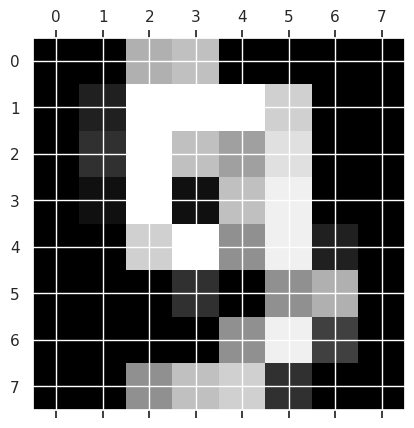

In [171]:
# Подивимось, що у нас знаходиться у датасеті
plt.gray()
plt.matshow(digits.images[9])
plt.show()

Датасет представляє собою 8x8 зображення цифр. Кожне значення датасета - це колір пікселя зображення у grayscale форматі, відображенний значеннями від 0 до 255.

In [172]:
# Проведемо первинний аналіз даних датасету
print("Загальний опис датасету:")
df.info()

Загальний опис датасету:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pixel_0_0  1797 non-null   float64
 1   pixel_0_1  1797 non-null   float64
 2   pixel_0_2  1797 non-null   float64
 3   pixel_0_3  1797 non-null   float64
 4   pixel_0_4  1797 non-null   float64
 5   pixel_0_5  1797 non-null   float64
 6   pixel_0_6  1797 non-null   float64
 7   pixel_0_7  1797 non-null   float64
 8   pixel_1_0  1797 non-null   float64
 9   pixel_1_1  1797 non-null   float64
 10  pixel_1_2  1797 non-null   float64
 11  pixel_1_3  1797 non-null   float64
 12  pixel_1_4  1797 non-null   float64
 13  pixel_1_5  1797 non-null   float64
 14  pixel_1_6  1797 non-null   float64
 15  pixel_1_7  1797 non-null   float64
 16  pixel_2_0  1797 non-null   float64
 17  pixel_2_1  1797 non-null   float64
 18  pixel_2_2  1797 non-null   float64
 19  pixel_2_3  1797 non-nul

In [173]:
# Перевіряємо чи є дублікати
df.duplicated().sum()

0

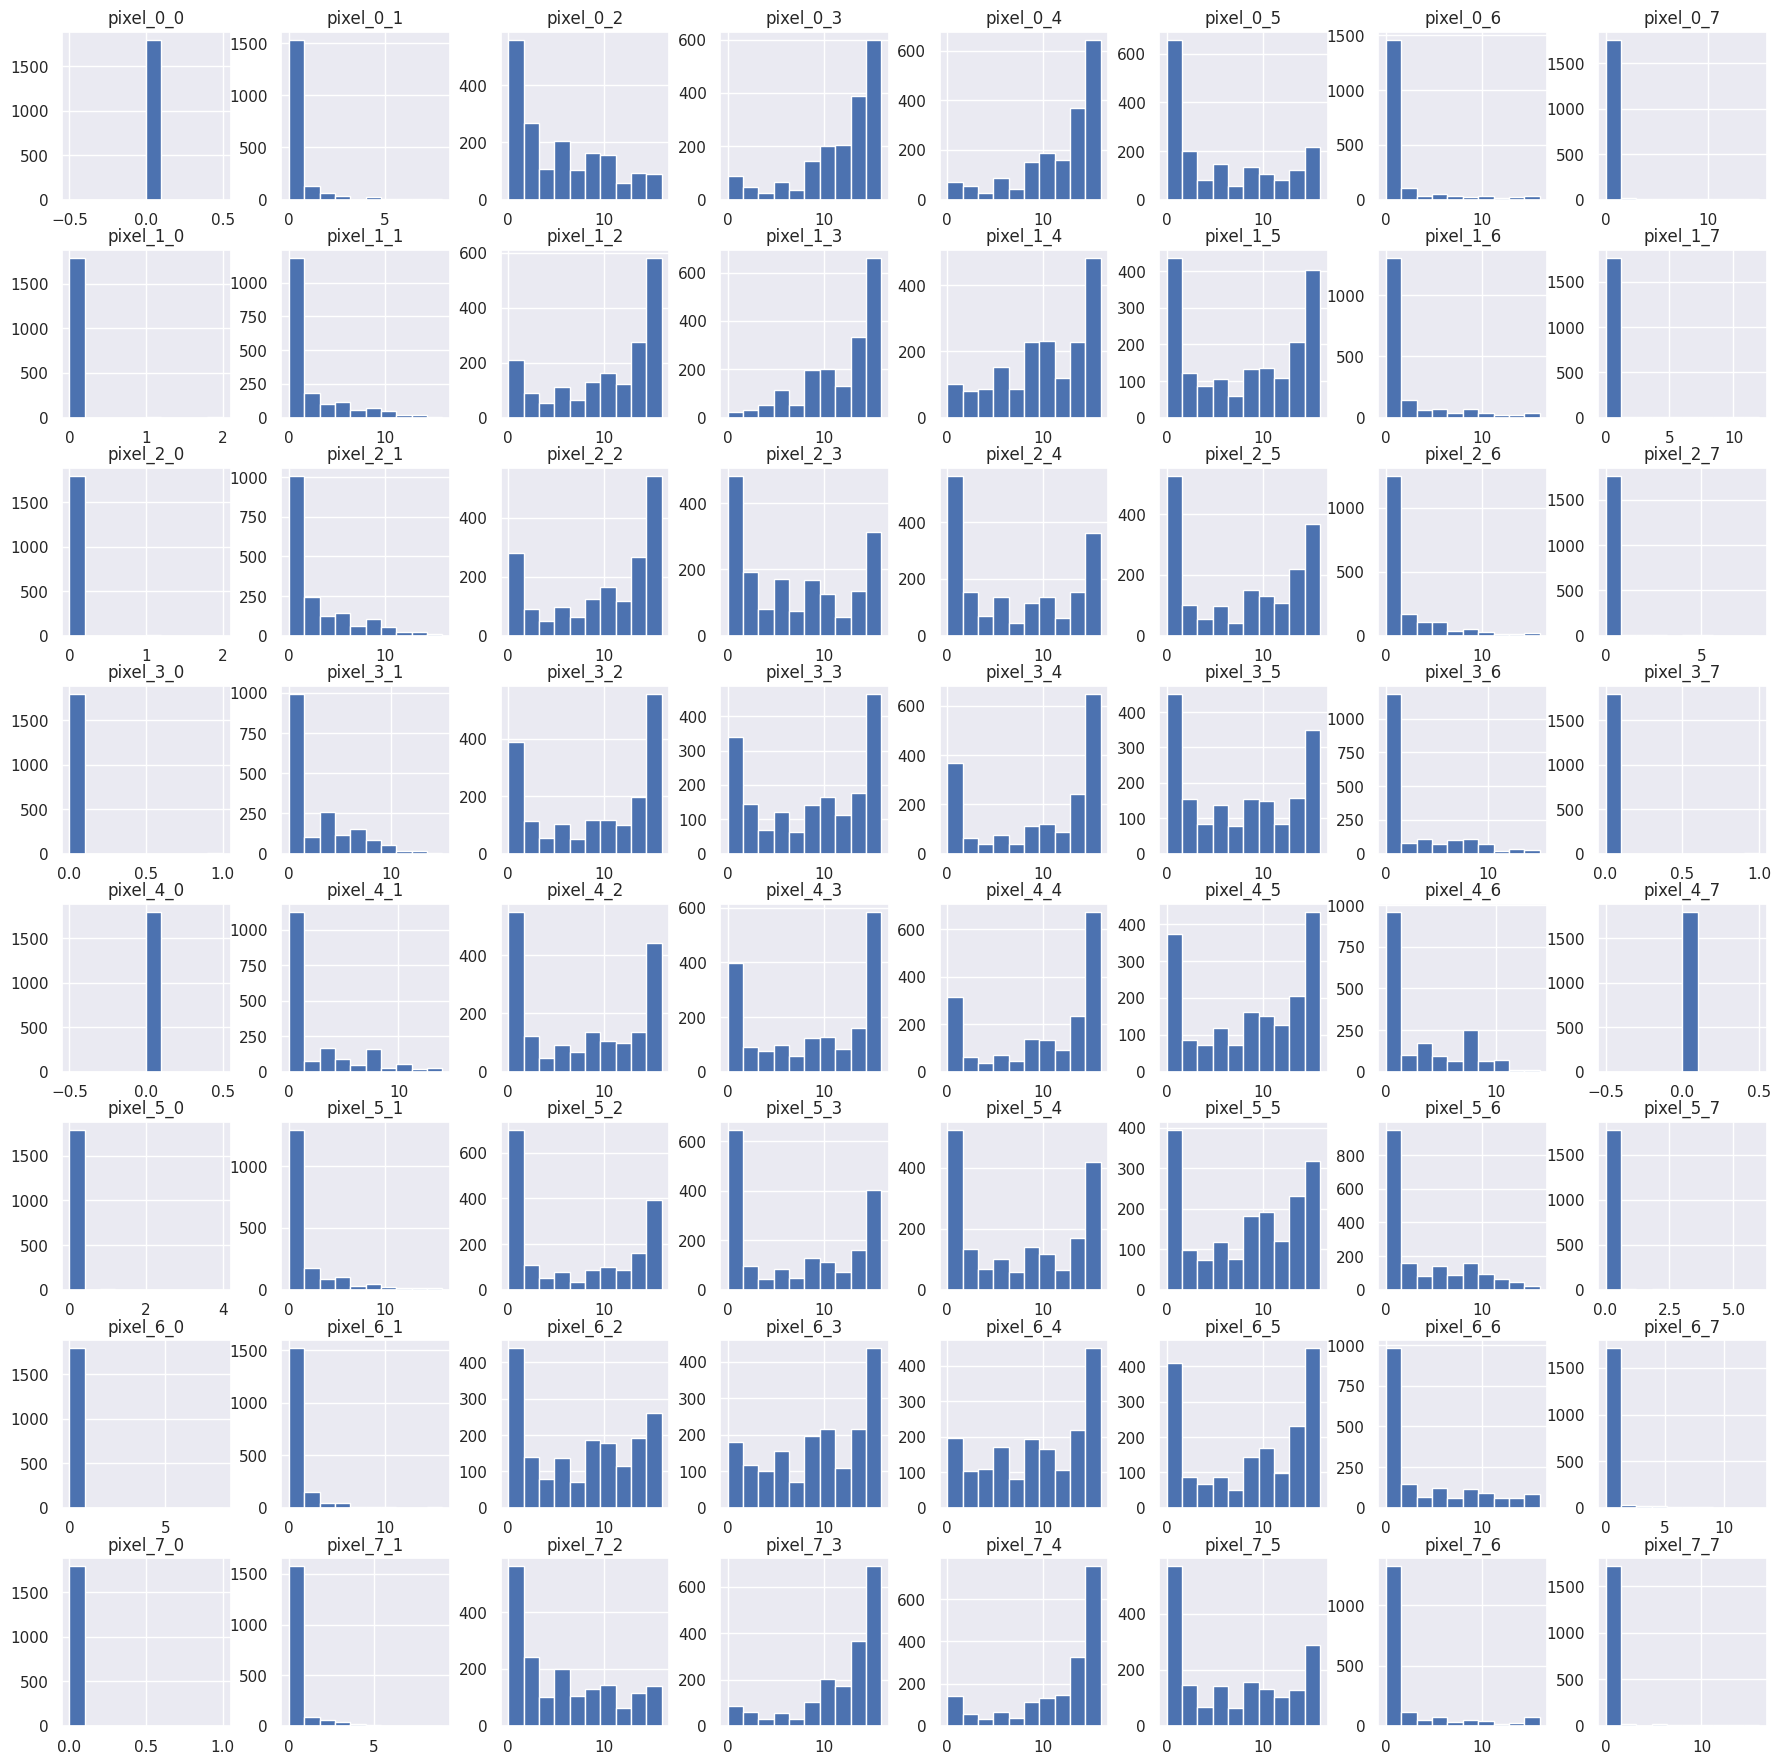

In [174]:
# Тепер подивимось на розподіл значень фічей
df.drop(columns="target").hist(figsize=(22, 22));

Є фічі, у яких по розподілу значень дуже переважає одне значення, а інші значення виглядають більше як аутлеєри.

<Axes: >

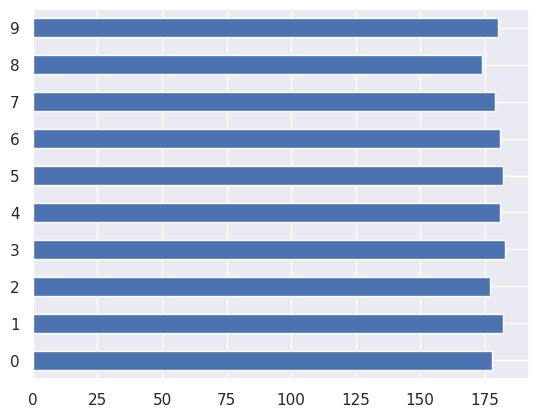

In [175]:
# Подивимось на розподіл по таргету
df["target"].value_counts(ascending=True).sort_index().plot(kind="barh")

<Axes: >

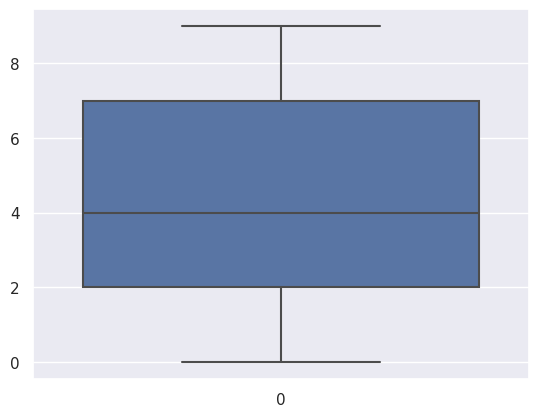

In [176]:
# Та глянемо скільки у нас статистичних викидів по таргету
sns.boxplot(df["target"])

Можемо побачити, що датасет доволі сбалансований, аутлайнерів не має.
Тепер подивимось як буде працювати моделі лінійної регресії та SVC з датасетом "з коробки".

# Тренування моделі на первинному датасеті

In [177]:
# Розбиваємо датасет на X та Y
X = df.drop(columns="target")  # фічі
Y = df["target"]  # таргет

In [178]:
# Зробимо масштабування фіч використовуючи MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [179]:
# Ділимо датасет на тренувальну, валідаційну та тестові частини за схемою 60-20-20
from sklearn.model_selection import train_test_split

x_train, x_rem, y_train, y_rem = train_test_split(X, Y, train_size=0.6, random_state=42, stratify=Y)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

In [180]:
# Спочатку побудуємо модель LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

grid_search = GridSearchCV(
    estimator=LinearSVC(),
    param_grid={
        "loss": ["hinge", "squared_hinge"],
        "dual": ["auto", True, False],
        "C": [1, 3, 5, 10],
        "multi_class": ["ovr", "crammer_singer"],
        "fit_intercept": [True, False],
        "intercept_scaling": [1, 3, 5, 10],
        "random_state": [42],
        "max_iter": [1000, 2000, 5000],
    },
)
grid_search.fit(x_valid, y_valid)

print("Результати тюнінгу гіперпараметрів для LinearSVC:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
linear_svc = grid_search.best_estimator_
linear_svc.fit(x_train, y_train)
predict = linear_svc.predict(x_test)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test, predict))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Результати тюнінгу гіперпараметрів для LinearSVC: 

Найкращі параметри: {'C': 1, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 10, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'crammer_singer', 'random_state': 42}
Найкращий score: 0.9444053208137714 

Результати тренування моделі:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.94      0.92      0.93        37
           2       1.00      0.97      0.99        35
           3       0.97      1.00      0.99        37
           4       1.00      0.97      0.99        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       0.92      1.00      0.96        36
           8       0.89      0.91      0.90        35
           9       1.00      0.94      0.97        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       3

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC на цьому датасеті показує чудовий результат! Давайте подивимось, чи можемо ми ще їх покращити з SVC моделлю.

In [181]:
# Будуємо SVC
from sklearn.svm import SVC
from sklearn.metrics import classification_report


grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid={
        "C": [1.0, 3.0, 5.0, 10.0],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": [3, 5, 7],
        "gamma": ["scale", "auto"],
        "shrinking": [True, False],
        "probability": [False, True],
        "random_state": [42],
    },
)
grid_search.fit(x_valid, y_valid)

print("Результати тюнінгу гіперпараметрів для SVC:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
svc = grid_search.best_estimator_
svc.fit(x_train, y_train)
predict = svc.predict(x_test)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test, predict))

Результати тюнінгу гіперпараметрів для SVC: 

Найкращі параметри: {'C': 3.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'probability': False, 'random_state': 42, 'shrinking': True}
Найкращий score: 0.9805164319248828 

Результати тренування моделі:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.97      1.00      0.99        37
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        37
           6       1.00      1.00      1.00        36
           7       0.97      1.00      0.99        36
           8       1.00      0.97      0.99        35
           9       1.00      0.97      0.99        36

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.9

SVC показує максимально гарний результат. Давайте тепер спробуємо зробити фіча-інженірінг та подивимось, як це вплине на фінальну якість моделі на цьому датасеті.

# Feature engineering

In [182]:
# Спробуємо прибрати фічі, які мають переважно одне значення
df = df.drop(
    columns=[
        "pixel_0_0",
        "pixel_0_7",
        "pixel_1_0",
        "pixel_1_7",
        "pixel_2_0",
        "pixel_2_7",
        "pixel_3_0",
        "pixel_3_7",
        "pixel_4_0",
        "pixel_4_7",
        "pixel_5_0",
        "pixel_5_7",
        "pixel_6_0",
        "pixel_6_7",
        "pixel_7_0",
        "pixel_7_7",
    ],
)

In [183]:
# Тепер зменшимо кількість фіч, склавши значення усіх фіч для кожного рядка у нову фічу
for i in range(0, 8):
    cols = [c for c in df.columns if f"pixel_{i}" in c]
    df[f"pixel_{i}"] = df[cols].sum(axis=1)
    df = df.drop(columns=cols)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   target   1797 non-null   int64  
 1   pixel_0  1797 non-null   float64
 2   pixel_1  1797 non-null   float64
 3   pixel_2  1797 non-null   float64
 4   pixel_3  1797 non-null   float64
 5   pixel_4  1797 non-null   float64
 6   pixel_5  1797 non-null   float64
 7   pixel_6  1797 non-null   float64
 8   pixel_7  1797 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 126.5 KB


In [184]:
# Тепер подивимось на кореляцію
sns.pairplot(df, hue="target");

Output hidden; open in https://colab.research.google.com to view.

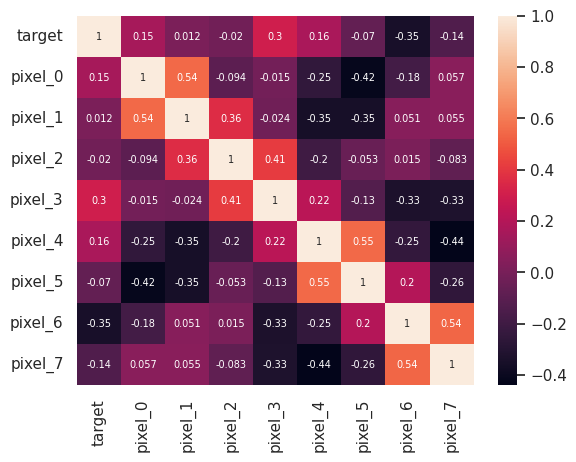

In [185]:
# Та побудуємо хітмап
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 7});

Бачимо, що в цілом фічі між собою не корелюють. Тепер подивимось як feature engineering на цьому датасеті вплинув на фінальну якість моделі SVC.

# Перевірка моделі після feature engineering

In [186]:
# Розбиваємо датасет на X та Y
X = df.drop(columns="target")  # фічі
Y = df["target"]  # таргет

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

x_train, x_rem, y_train, y_rem = train_test_split(X, Y, train_size=0.6, random_state=42, stratify=Y)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

In [187]:
# Перевіримо LinearSVC
linear_svc.fit(x_train, y_train)
predict = linear_svc.predict(x_test)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test, predict))

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64        35
           1       0.64      0.49      0.55        37
           2       0.68      0.86      0.76        35
           3       0.78      0.57      0.66        37
           4       0.94      0.92      0.93        36
           5       0.74      0.70      0.72        37
           6       0.88      0.97      0.92        36
           7       0.76      0.97      0.85        36
           8       0.60      0.51      0.55        35
           9       0.76      0.86      0.81        36

    accuracy                           0.75       360
   macro avg       0.74      0.75      0.74       360
weighted avg       0.74      0.75      0.74       360



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [188]:
# Перевіримо SVC модель
svc.fit(x_train, y_train)
predict = svc.predict(x_test)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test, predict))

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        35
           1       0.69      0.73      0.71        37
           2       0.93      0.80      0.86        35
           3       0.82      0.86      0.84        37
           4       0.95      0.97      0.96        36
           5       0.91      0.78      0.84        37
           6       0.92      0.97      0.95        36
           7       0.95      0.97      0.96        36
           8       0.66      0.66      0.66        35
           9       0.94      0.92      0.93        36

    accuracy                           0.84       360
   macro avg       0.84      0.84      0.84       360
weighted avg       0.85      0.84      0.84       360



Як ми бачимо, після feature engineering результати обох моделей погіршилися. Тож цей датасет краще використовувати без додаткових трансформацій, або спробувати інші зміни.

# Візуалізація роботи моделі

Тепер на прикладі двох фіч зробимо візуалізацію роботи моделі з різними параметрами.

In [189]:
X = df[["pixel_0", "pixel_1"]]  # фічі
Y = df["target"]  # таргет

X = scaler.fit_transform(X)

x_train, x_rem, y_train, y_rem = train_test_split(X, Y, train_size=0.6, random_state=42, stratify=Y)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

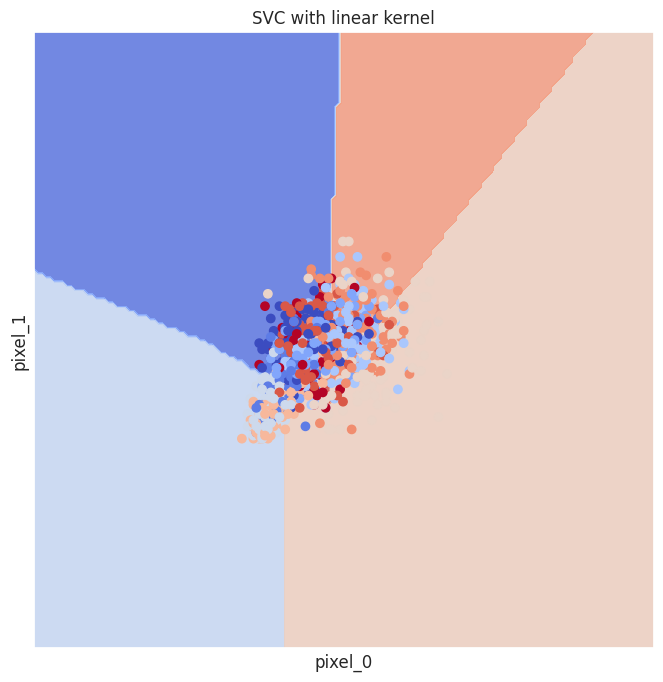

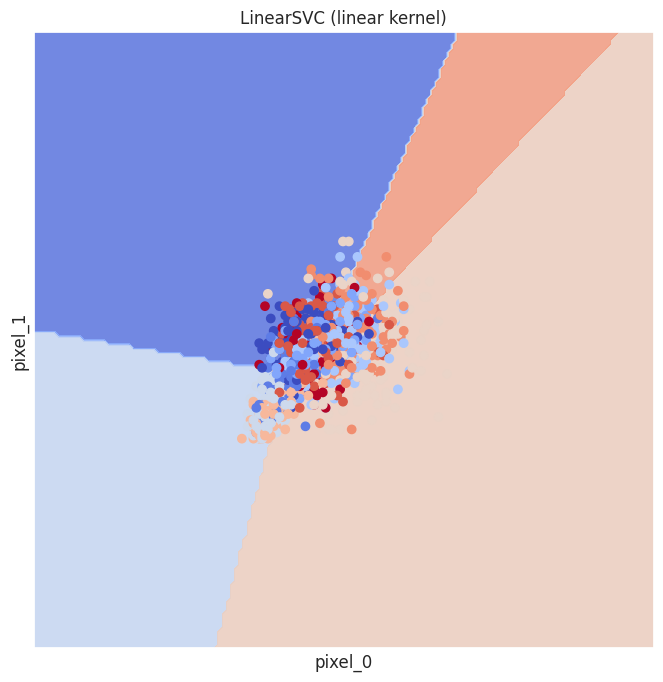

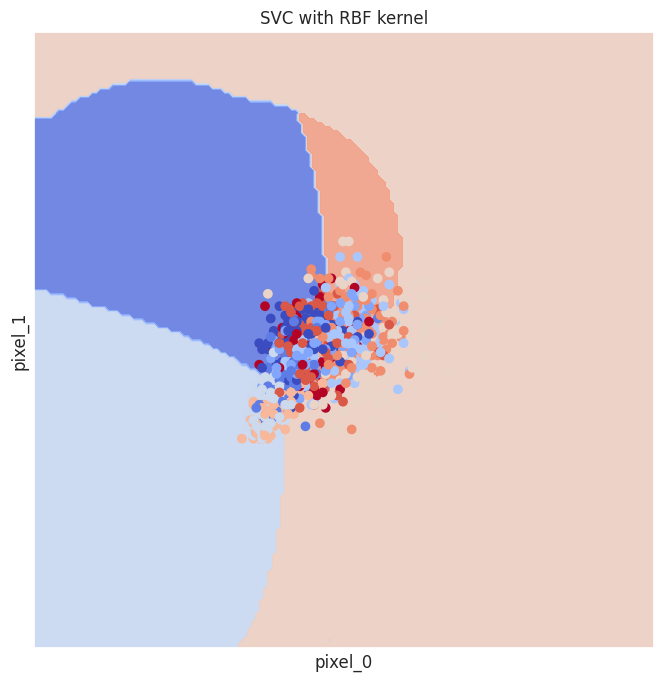

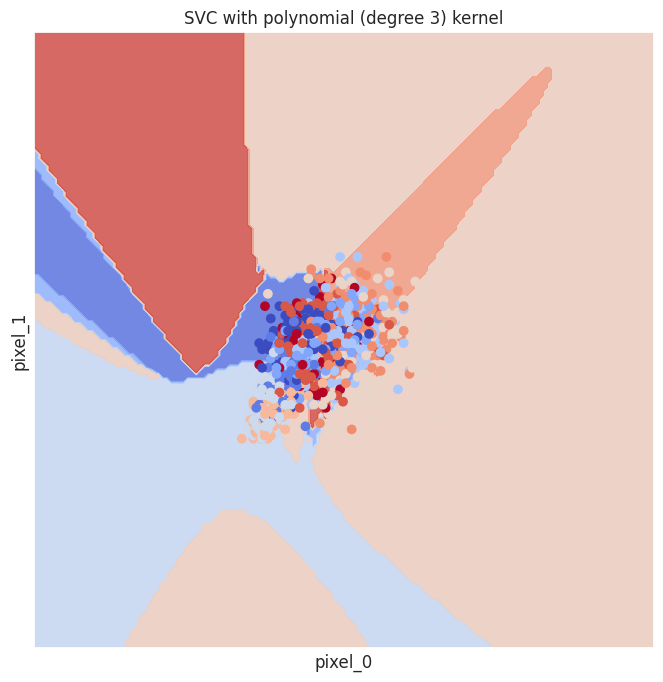

In [190]:
# Код був честно стягнутий з https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html

h = .02  # шаг сітки
C = 1.0  # параметр регулярізації SVM

svc = SVC(kernel="linear", C=C).fit(x_train, y_train)
rbf_svc = SVC(kernel="rbf", gamma=0.7, C=C).fit(x_train, y_train)
poly_svc = SVC(kernel="poly", degree=3, C=C).fit(x_train, y_train)
lin_svc = LinearSVC(C=C).fit(x_train, y_train)

x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h),
)

# Назви графіків
titles = [
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
]


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    plt.figure(figsize=(8, 8))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)



    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)
    plt.xlabel('pixel_0')
    plt.ylabel('pixel_1')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])


plt.show()

Як можна побачити, лінійні моделі SVC з ядром `linear` та LinearSVC мають більш лінійні границі, а нелінійні моделі ядра мають більш гнучкі нелінійні границі рішень, форма яких залежить від ядра та його параметрів.

# Висновок

В ході домашньої роботи ми ознайомились з класифікатором SVC та побачили, що для поточного датасету SVC непогано працює навіть без додаткових маніпуляцій з даними. Можно зробити висновок, що SVM може показати дуже непогані результати на датасеті невеликого розміру. Також ми подивились графічно як будують границі рішень різні ядра моделі.